In [93]:
""" A small example illustrating the functioning of the computational graph for quantum circuits"""

# let's first build a sample circuit
# for instance a 3 qubits QFT
from qibo import Circuit, gates

# a QFT layer
def qft_layer(q, nqubits):
    c = Circuit(nqubits)
    c.add(gates.H(q))
    for i in range(1, q + 1):
        c.add(gates.CRZ(q - i, q, theta=0.))
    return c

nqubits = 4
c = Circuit(4)

for q in reversed(range(nqubits)): 
    c += qft_layer(q, nqubits)
c.add(gates.SWAP(0,3))
c.add(gates.SWAP(1,2))
#c.add([gates.M(i) for i in range(nqubits)])
print(c.draw())


q0: ─────────o───────o────o──H─x───
q1: ──────o──|────o──|──H─RZ───|─x─
q2: ───o──|──|──H─RZ─RZ────────|─x─
q3: ─H─RZ─RZ─RZ────────────────x───


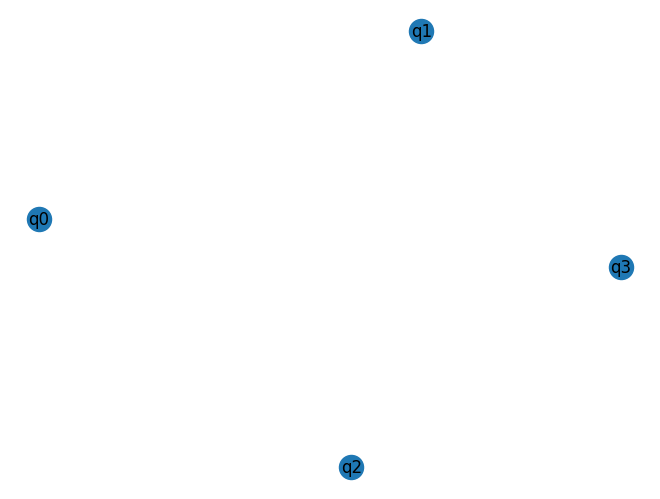

In [94]:
# now let's try to construct the computation graph that represents the circuit:
# each node of the graph will represent an operation of the circuit, i.e. the
# application of a gate. A directed edge between two nodes represents the dependency 
# between two operations, namely the target node requires the source node to be
# processed first.
# Each node will contain all the information necessary to build the circuit:
# Node : {
# index --> index of the node   
# gatename --> identifier of the gate
# qubit --> qubit of application
# control (optional) --> the controlling qubit/s
# }
# The edges only record directed connections between nodes:
# Edge: {
# index --> edge index
# source --> source node
# target --> target node
# }
# Together with the nodes and edges, we need to keep track of the current lastly 
# added nodes for each one of the wires (qubits). Therefore, we gradually update
# a list of nqubits nodes whenever a new gate is added.

import networkx as nx

g = nx.DiGraph()

# we start from the qubits untouched
wires_ends = list(range(nqubits))
g.add_nodes_from(wires_ends)
labels = {i: f"q{i}" for i in wires_ends} 
nx.draw(g, labels=labels, with_labels=True)

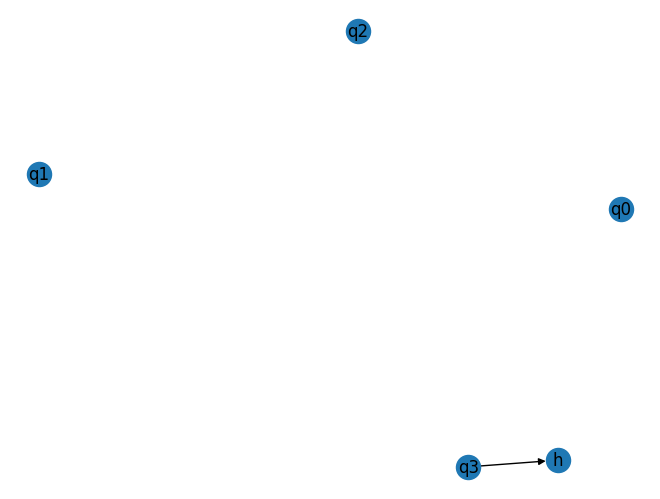

In [95]:
# the first node is the H(3)
index = 4
g.add_node(index, gate="h", qubit=3)
# is connected to the third wire, add edge
g.add_edge(wires_ends[3], index)
# update the third end
wires_ends[3] = index
labels[index] = "h"
nx.draw(g, labels=labels, with_labels=True)

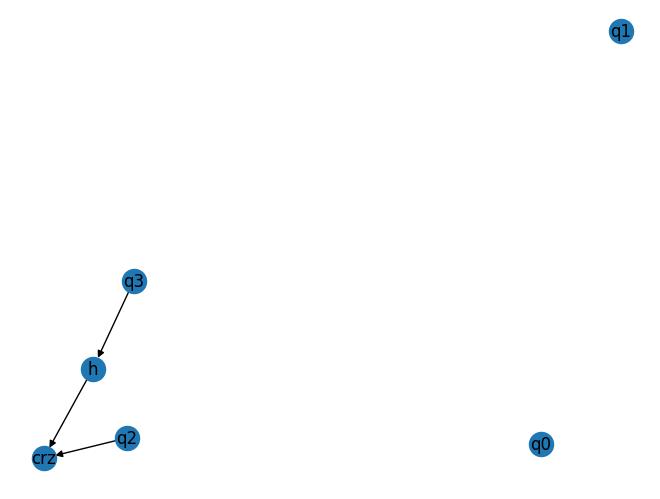

In [96]:
# the second is a CRZ(3,2)
index = 5
g.add_node(index, gate="crz", qubit=2, control=3)
# connected to the third and second ends
g.add_edge(wires_ends[3], index)
g.add_edge(wires_ends[2], index)
# since two different wires are involved we update both of them
wires_ends[3] = index
wires_ends[2] = index
labels[index] = "crz"
nx.draw(g, labels=labels, with_labels=True)


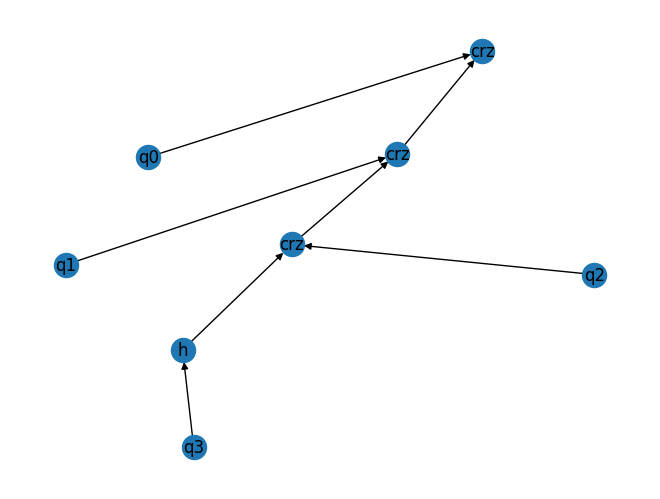

In [97]:
# then CRZ(3,1)
index = 6
g.add_node(index, gate="crz", qubit=1, control=3)
g.add_edge(wires_ends[3], index)
g.add_edge(wires_ends[1], index)
wires_ends[3] = index
wires_ends[1] = index
labels[index] = "crz"
# and CRZ(3,0)
index = 7
g.add_node(1, gate="crz", qubit=1, control=3)
g.add_edge(wires_ends[3], index)
g.add_edge(wires_ends[0], index)
wires_ends[3] = index
wires_ends[0] = index
labels[index] = "crz"
nx.draw(g, labels=labels, with_labels=True)

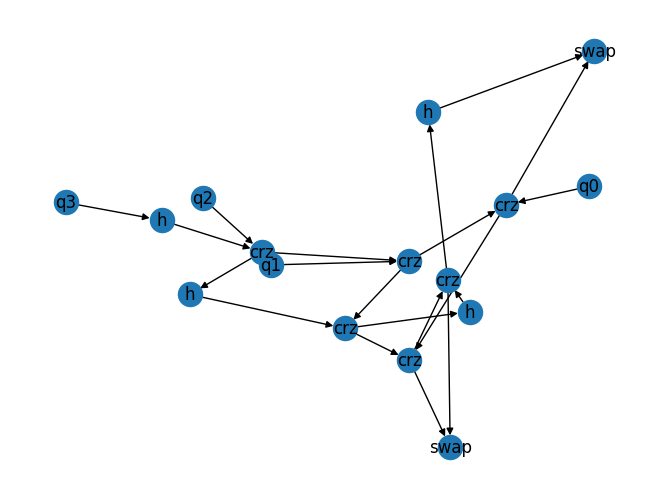

In [98]:
# then if we add all the others

for gate in c.queue[4:]:
    index += 1
    kwargs = {
        "gate": gate.name,
        "qubit": gate.target_qubits[0],
    }
    if len(gate.control_qubits) > 0:
        kwargs["control"] = gate.control_qubits[0]
    g.add_node(index, **kwargs)
    for q in gate.qubits:
        g.add_edge(wires_ends[q], index)
        wires_ends[q] = index
    labels[index] = gate.name
        
nx.draw(g, labels=labels, with_labels=True)